# Use Keras to transfer image style with `ibm-watson-machine-learning`

This notebook contains the steps and code required to demonstrate style transfer technique using Watson Machine Learning Service. It introduces commands for getting data, training_definition persistance to Watson Machine Learning repository and model training.

Some familiarity with Python is helpful. This notebook uses Python 3.8.


## Learning goals


The learning goals of this notebook are:

-  Working with Watson Machine Learning service.
-  Training Deep Learning models (Keras).


## Contents


1.	[Setup](#setup)
2.	[Create model definition](#model_def)
3.  [Create experiment](#experiment)
4.	[Train model](#train)
5.  [Results](#results)
6.  [Clean up](#clean)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [ ]:
api_key = 'PASTE YOUR PLATFORM API KEY HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [ ]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install ibm-watson-machine-learning

In [2]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [ ]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

### 1.1 Working with Cloud Object Storage

-  Create a [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered and information about how to order storage is [here](https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage)).
    - After you create COS instance, go to your COS dashboard.
    - In **Service credentials** tab, click **New Credential**.
    - Add the inline configuration parameter: {["HMAC"](https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials):true}, click **Add**.

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "***",
            "secret_access_key": "***"
       }
    ```

Import the Boto library, which allows Python developers to manage COS.

In [5]:
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
import urllib
import time
warnings.filterwarnings('ignore')

**Action**: Enter your COS credentials in the following cell.  
You can find these credentials in your COS instance dashboard under the **Service credentials** tab.  
**Note** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

In [6]:
cos_credentials = {
  "apikey": "***",
  "cos_hmac_keys": {
    "access_key_id": "***",
    "secret_access_key": "***"
  },
  "endpoints": "***",
  "iam_apikey_description": "***",
  "iam_apikey_name": "***",
  "iam_role_crn": "***",
  "iam_serviceid_crn": "***",
  "resource_instance_id": "***"
}

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'

Create the Boto resource by providing type, endpoint_url and credentials.

In [7]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Create the buckets you will use to store training data and training results.

**Note:** Bucket names must be unique.

In [8]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "training-data-c2d261bb-a928-4d5f-a5bc-24b1fb174a95"...
Creating bucket "training-results-c2d261bb-a928-4d5f-a5bc-24b1fb174a95"...


You have now created two new buckets.  
Display a list of buckets for your COS instance to verify that the buckets were created.

In [ ]:
# Display the buckets
print(list(cos.buckets.all()))

### 1.2 Download training data and upload it to COS buckets<a id="download"></a>

Download your training data and upload them to the 'training-data' bucket.
Then, create a list of links for training dataset.

The following code snippet creates the `STYLE_DATA` folder and downloads the files from the links to the folder.

In [9]:
# Create folder
data_dir = 'STYLE_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

links = ['https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
         'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1513px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
         'https://upload.wikimedia.org/wikipedia/commons/5/52/Krak%C3%B3w_239a.jpg',
         'https://upload.wikimedia.org/wikipedia/commons/3/3f/Kandinsky%2C_Lyrisches.jpg']

# Download the links to the folder
for i in range(len(links)):
    if 'Gogh' in links[i]: 
        filepath = os.path.join(data_dir, 'van_gogh.jpg')
    elif 'Krak' in links[i]: 
        filepath = os.path.join(data_dir, 'krakow.jpg')
    elif 'Kandinsky' in links[i]:
        filepath = os.path.join(data_dir, 'kandinsky.jpg')
    else:
        filepath = os.path.join(data_dir, os.path.join(links[i].split('/')[-1]))

    if not os.path.isfile(filepath):
        print(links[i])
        urllib.request.urlretrieve(links[i], filepath)

# List the files in the STYLE_DATA folder        
!ls STYLE_DATA

kandinsky.jpg
krakow.jpg
van_gogh.jpg
vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5


### Base image: Cracow - main market square

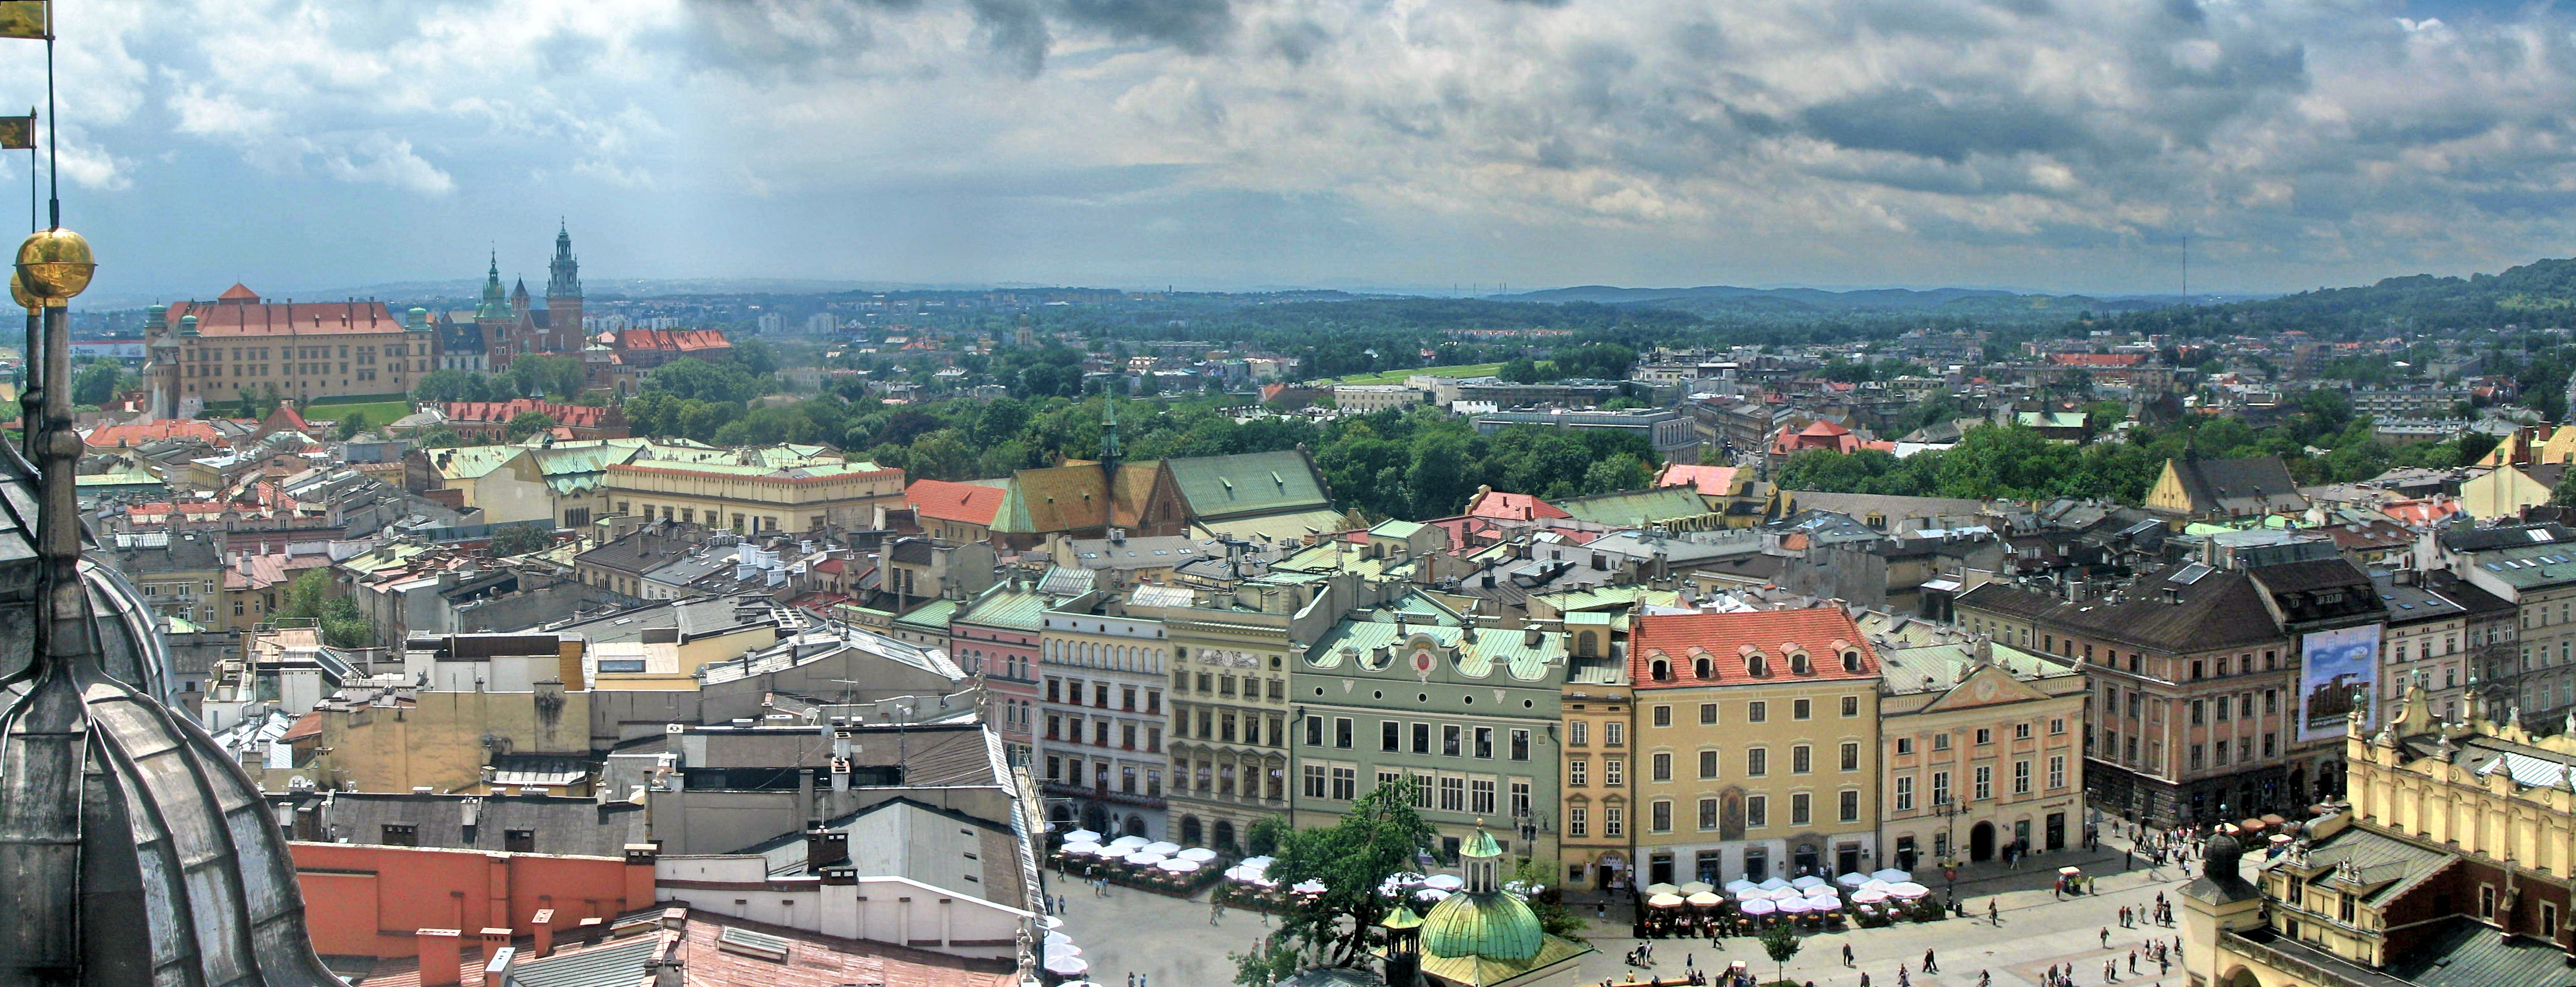

In [10]:
from IPython.display import Image
Image(filename=os.path.join(data_dir, 'krakow.jpg'), width=1000)

### Style image 1: Vincent Van Gogh - Starry Night

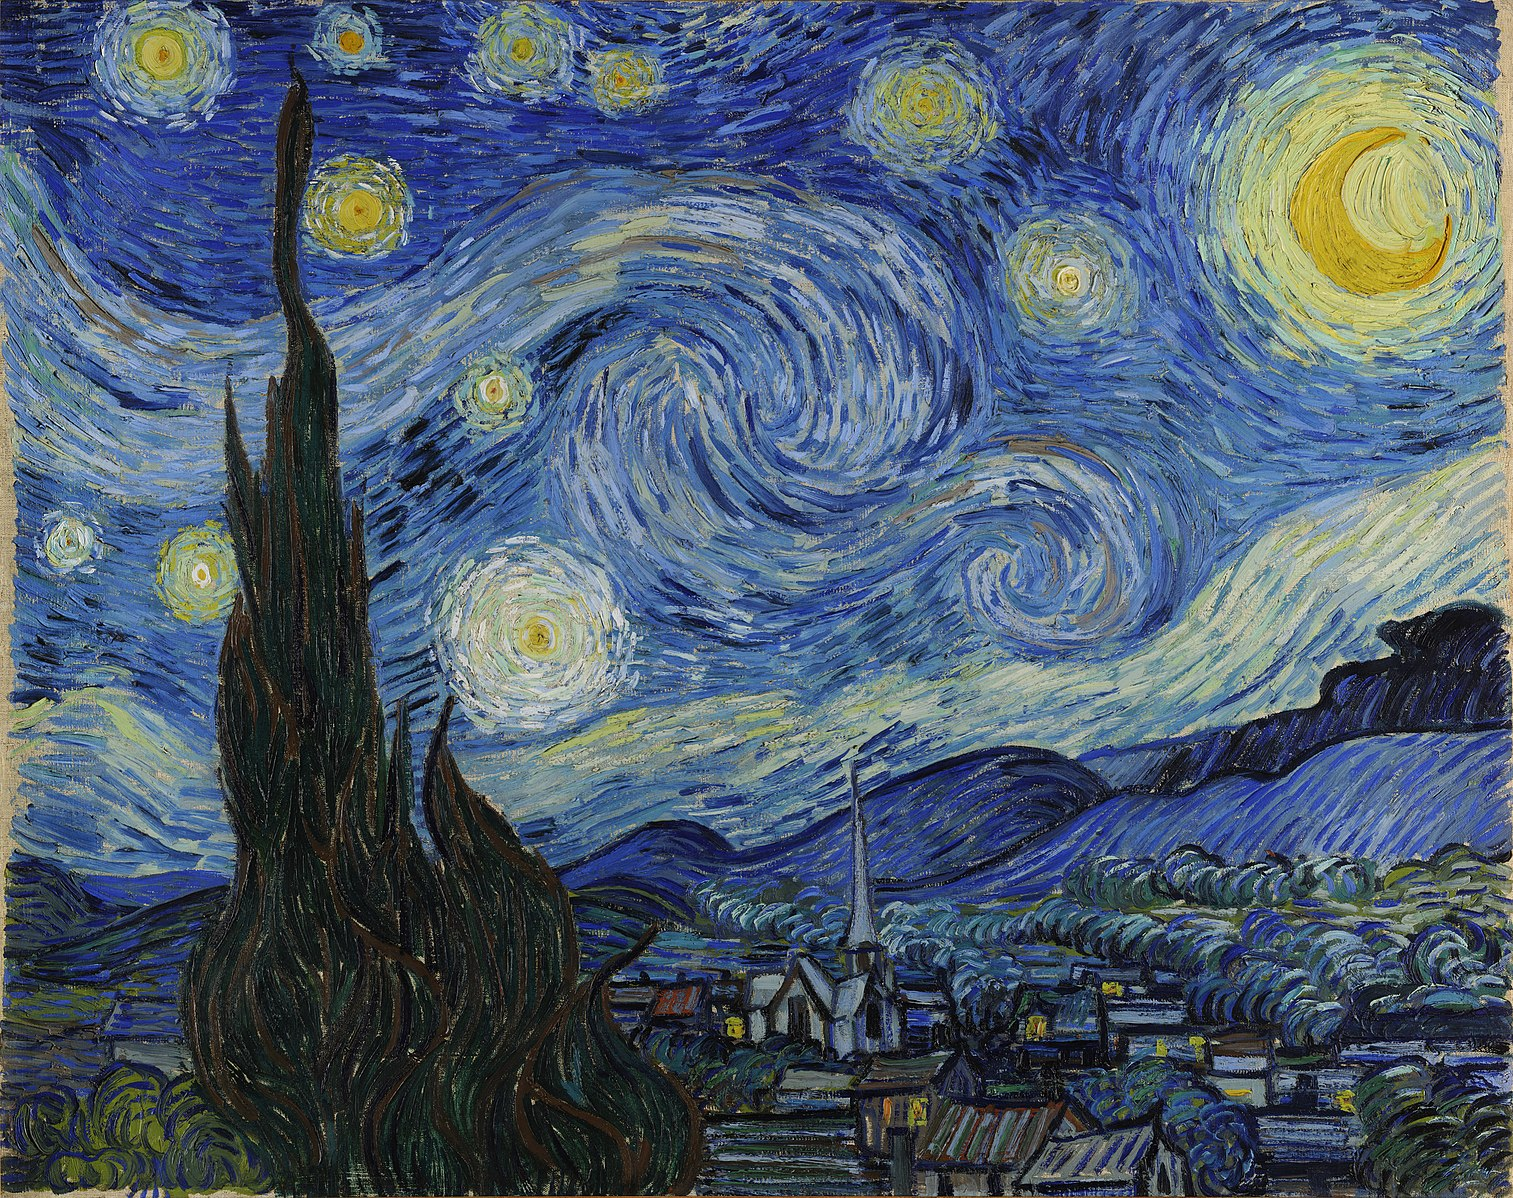

In [11]:
Image(filename=os.path.join(data_dir, 'van_gogh.jpg'), width=500)

<HR>

### Style image 2: Kandinsky Lyrisches

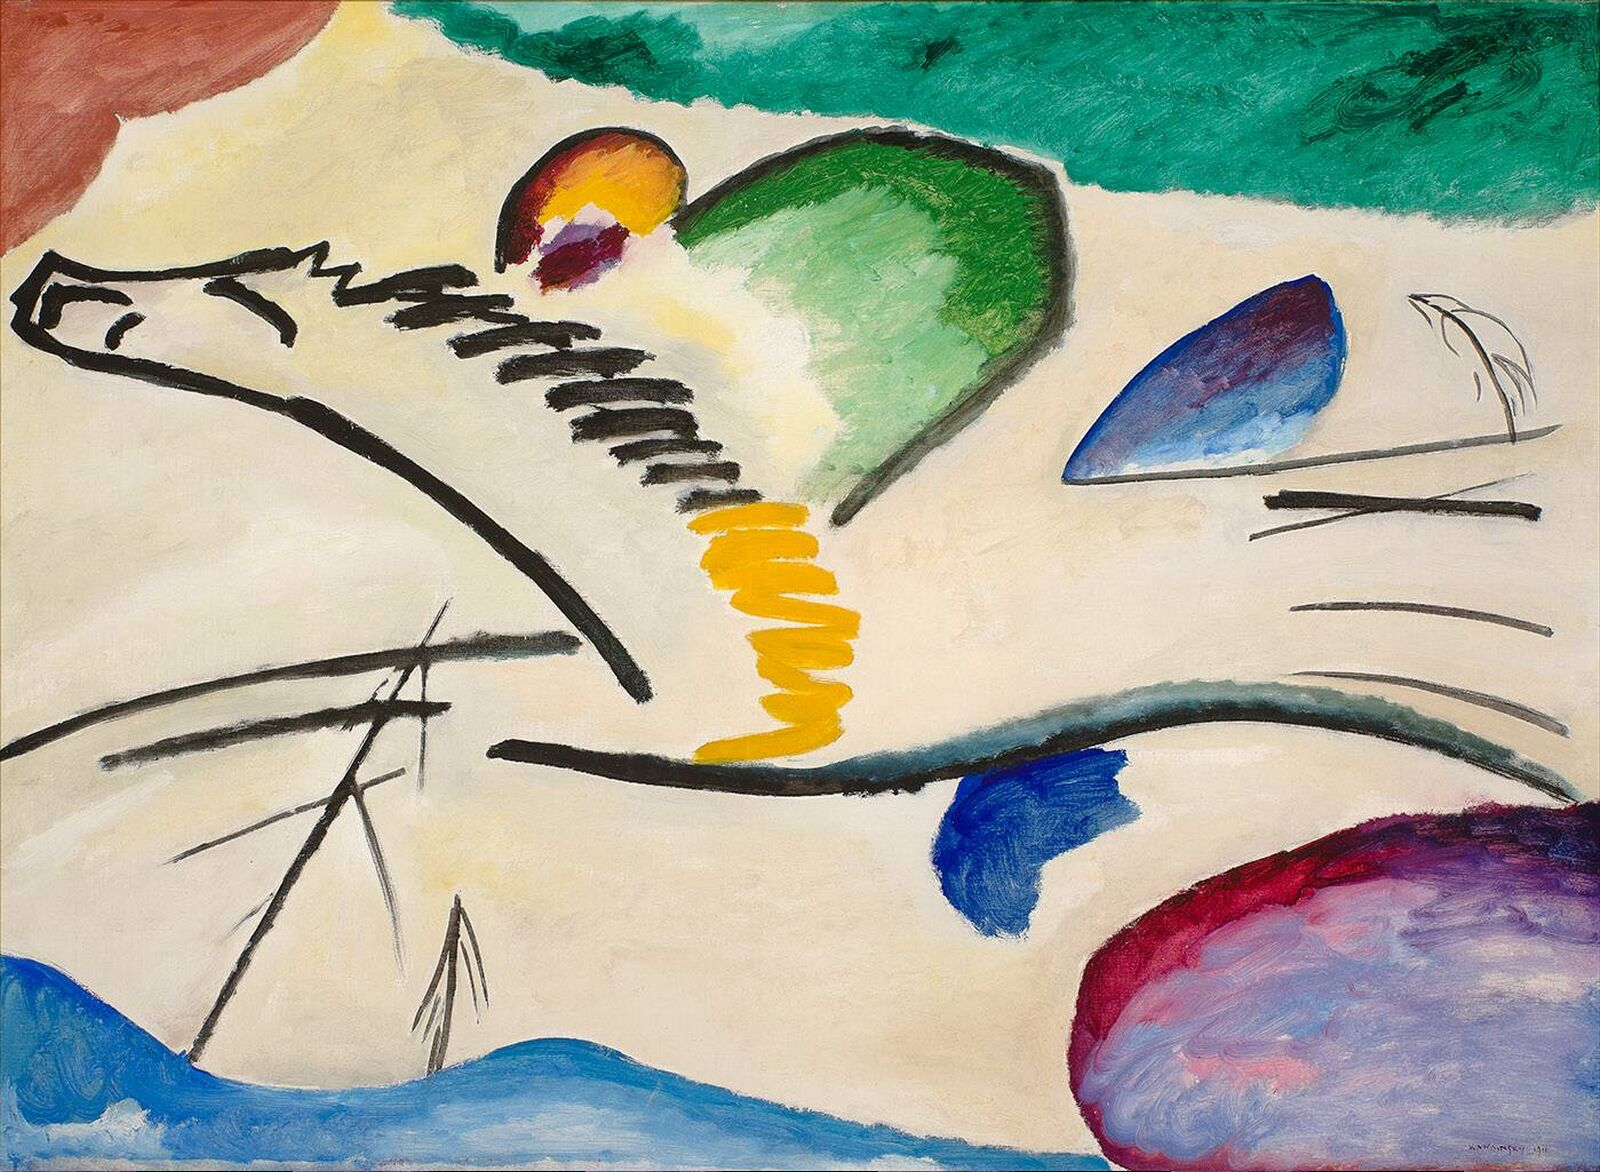

In [12]:
Image(filename=os.path.join(data_dir, 'kandinsky.jpg'), width=600)

Upload the data files to the created buckets.

In [13]:
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

In [14]:
for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

van_gogh.jpg is uploaded.
kandinsky.jpg is uploaded.
krakow.jpg is uploaded.
vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5 is uploaded.


Let's see the list of all the buckets and their contents.

In [ ]:
for obj in bucket_obj.objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

### 1.3 Create connections to a COS bucket.

In [13]:
datasource_type = client.connections.get_datasource_type_uid_by_name('bluemixcloudobjectstorage')

input_conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: "Input COS connection",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: datasource_type,
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': buckets[0],
        'access_key': cos_credentials['cos_hmac_keys']['access_key_id'],
        'secret_key': cos_credentials['cos_hmac_keys']['secret_access_key'],
        'iam_url': auth_endpoint,
        'url': service_endpoint
    }
}

output_conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Output COS connection",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: datasource_type,
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': buckets[1],
        'access_key': cos_credentials['cos_hmac_keys']['access_key_id'],
        'secret_key': cos_credentials['cos_hmac_keys']['secret_access_key'],
        'iam_url': auth_endpoint,
        'url': service_endpoint
    }
}

input_conn_details = client.connections.create(meta_props=input_conn_meta_props)
output_conn_details = client.connections.create(meta_props=output_conn_meta_props)

Creating connections...
SUCCESS
Creating connections...
SUCCESS


In [14]:
input_connection_id = client.connections.get_uid(input_conn_details)
output_connection_id = client.connections.get_uid(output_conn_details)

You are done with COS, and you are now ready to train your model!

<a id="model_def"></a>
# 2. Create model definitions

### 2.1 Prepare model definition metadata

**Hint:** The final effect depends on number of iterations, and that the number of iterations impacts the training time.

In [15]:
# Set the number of iterations.
iters = 20

In [16]:
model_definition_1_metadata = {
    client.model_definitions.ConfigurationMetaNames.NAME: "style transfer van gogh",
    client.model_definitions.ConfigurationMetaNames.DESCRIPTION: "style transfer van gogh",
    client.model_definitions.ConfigurationMetaNames.COMMAND: f"python3 style_transfer.py krakow.jpg van_gogh.jpg krakow --iter {iters}",
    client.model_definitions.ConfigurationMetaNames.PLATFORM: {"name": "python", "versions": ["3.8"]},
    client.model_definitions.ConfigurationMetaNames.VERSION: "2.0",
    client.model_definitions.ConfigurationMetaNames.SPACE_UID: space_id
}

In [ ]:
model_definition_2_metadata = {
    client.model_definitions.ConfigurationMetaNames.NAME: "style transfer kandinsky",
    client.model_definitions.ConfigurationMetaNames.DESCRIPTION: "style transfer kandinsky",
    client.model_definitions.ConfigurationMetaNames.COMMAND: f"python3 style_transfer.py krakow.jpg kandinsky.jpg krakow --iter {iters}",
    client.model_definitions.ConfigurationMetaNames.PLATFORM: {"name": "python", "versions": ["3.8"]},
    client.model_definitions.ConfigurationMetaNames.VERSION: "2.0",
    client.model_definitions.ConfigurationMetaNames.SPACE_UID: space_id
}

### 2.2  Get sample model definition content file from git
**Hint:** You may need to install wget using following command `!pip install wget`

In [18]:
import wget
filename_definition = 'STYLE.zip'

if not os.path.isfile(filename_definition):
    filename_definition = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/definitions/keras/style_transfer/STYLE.zip')

**Tip**: Convert below cell to code and run it to see model deinition's code.

### 2.3  Publish model definitions

#### Store definition 1

In [19]:
model_definition_details_1 = client.model_definitions.store(filename_definition, model_definition_1_metadata)
model_definition_id_1 = client.model_definitions.get_id(model_definition_details_1)

#### Store definition 2

In [20]:
model_definition_details_2 = client.model_definitions.store(filename_definition, model_definition_2_metadata)
model_definition_id_2 = client.model_definitions.get_id(model_definition_details_2)

#### List the stored definitions

In [ ]:
client.model_definitions.list(limit=5)

<a id="experiment"></a>
# 3. Create deep learning experiment

### 3.1 Prepare experiment metadata

In [24]:
experiment_metadata = {
    client.repository.ExperimentMetaNames.NAME: "Transfer style experiment",
    client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
        {
            "model_definition": {
                "id": model_definition_id_1,
                "hardware_spec": {
                    "name": "K80",
                    "nodes": 1
                },
                "software_spec": {
                    "name": "tensorflow_2.4-py3.8"
                }
            }
        },
        {
            "model_definition": {
                "id": model_definition_id_2,
                "hardware_spec": {
                    "name": "K80",
                    "nodes": 1
                },
                "software_spec": {
                    "name": "tensorflow_2.4-py3.8"
                }
            }
        }
    ]
}


### 3.2  Publish experiment to repository

In [25]:
experiment_details = client.repository.store_experiment(
    meta_props=experiment_metadata
)
experiment_id = client.repository.get_experiment_id(experiment_details)

### 3.3 Get experiment details

In [37]:
print(json.dumps(client.experiments.get_details(experiment_id), indent=2))

{
  "entity": {
    "training_references": [
      {
        "model_definition": {
          "hardware_spec": {
            "id": "cf70f086-916d-4684-91a7-264c49c6d425",
            "name": "K80"
          },
          "id": "9c240e51-d2c3-4bc6-a6b1-8a9b72a23d58",
          "software_spec": {
            "id": "c4032338-2a40-500a-beef-b01ab2667e27",
            "name": "tensorflow_2.1-py3.7"
          }
        }
      },
      {
        "model_definition": {
          "hardware_spec": {
            "id": "cf70f086-916d-4684-91a7-264c49c6d425",
            "name": "K80"
          },
          "id": "a25a86ab-a569-45d8-b72b-39038d916187",
          "software_spec": {
            "id": "c4032338-2a40-500a-beef-b01ab2667e27",
            "name": "tensorflow_2.1-py3.7"
          }
        }
      }
    ]
  },
  "metadata": {
    "created_at": "2021-02-15T10:52:01.830Z",
    "id": "09ad3919-0eb8-438e-8f85-3f1c947f21db",
    "modified_at": "2021-02-15T10:52:01.830Z",
    "name": "Transfer st

<a id="train"></a>
# 4. Train model

### 4.1 Prepare models definitions metadata

In [27]:
training_metadata = {
   client.training.ConfigurationMetaNames.NAME: "style transfer van gogh",
    client.training.ConfigurationMetaNames.SPACE_UID: space_id,
    client.training.ConfigurationMetaNames.DESCRIPTION: "test training modeldef style transfer van gogh",
    client.training.ConfigurationMetaNames.TAGS :[{
      "value": "keras transfer image style",
      "description": "apply van gogh style to images"
    }],
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE:  {
    "name": "MNIST results",
    "type": "connection_asset",
    "connection": {
        "id": output_connection_id,
    },
    "location": {
        "bucket": buckets[1],
        "file_name": "."
    },
  },
  client.training.ConfigurationMetaNames.EXPERIMENT:{
        "id": experiment_id,
  },
  client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: [
       {
      "name": "training_input_data",
      "type": "connection_asset",
      "connection": {
          "id": input_connection_id,
      },
      "location": {
        "bucket": buckets[0],
        "file_name": "."
      },
      "schema": {
        "id":"idmlp_schema",
        "fields": [
          {
            "name": "text",
            "type": "string"
          }
        ]
      }
    }
  ]
}

### 4.2 Train models in background

In [28]:
training = client.training.run(training_metadata)

### 4.3 Get training id and status

In [29]:
training_id = client.training.get_id(training)

In [34]:
print(client.training.get_status(training_id))

{'completed_at': '2021-02-15T10:57:08.909Z', 'running_at': '2021-02-15T10:52:17.277Z', 'state': 'completed'}


### 4.4 Get trainings details

In [ ]:
training_details= client.training.get_details(training_id)
print(json.dumps(training_details, indent=2))

#### List trainings

In [ ]:
client.training.list(limit=5)

#### Cancel training

You can cancel the training run by calling the method below.  
**Tip**: If you want to  delete train runs and results add `hard_delete=True` as a parameter.  
**Tip**: Pick one of training_id_1 or training_id_2.

<a id="results"></a>
# 5. Results - transferred styles images

#### Download transfered transfered photos of Cracow from COS

In [38]:
bucket_name = buckets[1]
bucket_obj = cos.Bucket(bucket_name)

In [40]:
transfered_images = []
model_id = 0

for obj in bucket_obj.objects.iterator():
        if model_id == 2:
            break
        if f"transfered_images/krakow_at_iteration_{iters}.png" in obj.key:
            image_name = f"transfered_krakow_{model_id}.png"
            transfered_images.append(image_name)
            model_id += 1

            bucket_obj.download_file(obj.key, image_name)

### Cracow

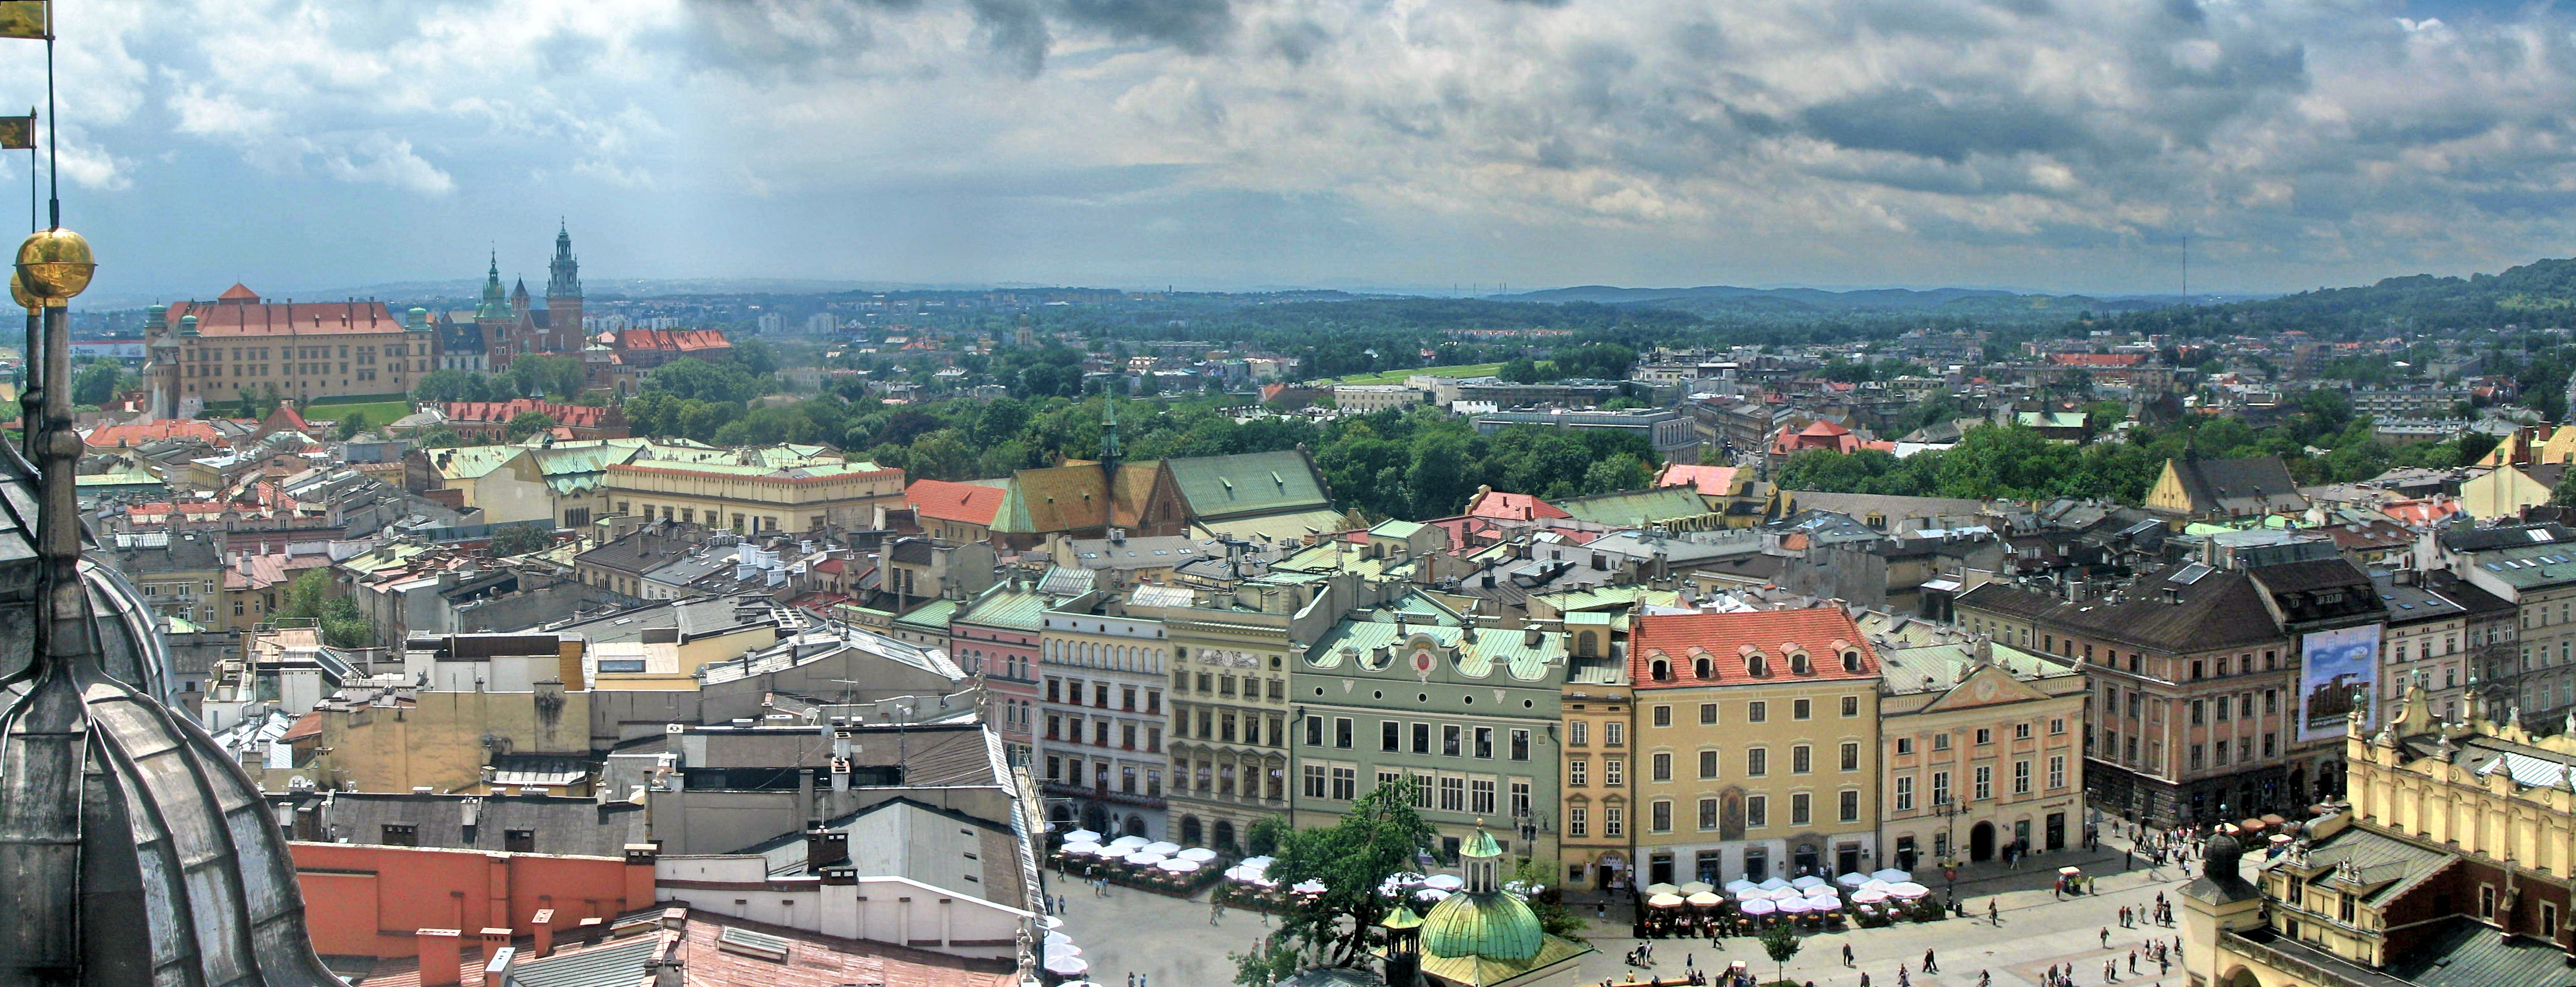

In [41]:
Image(filename=os.path.join(data_dir, 'krakow.jpg'), width=1000)

### Transfered Images

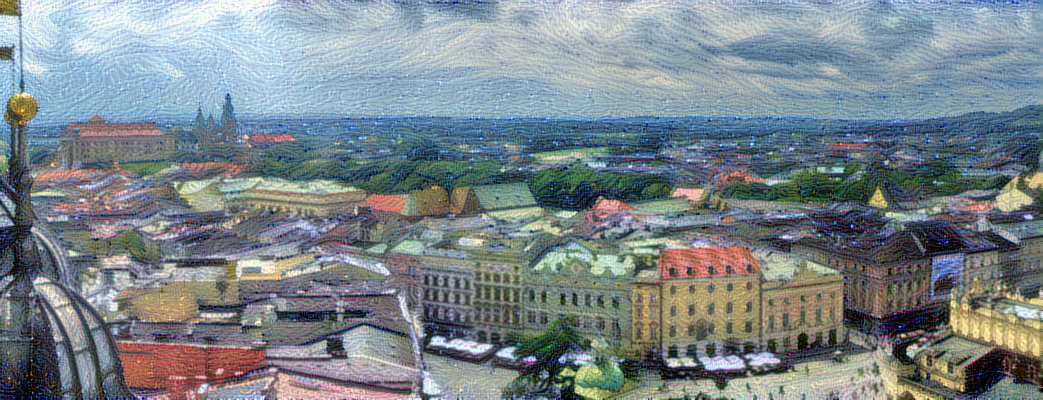

In [38]:
Image(filename=transfered_images[0], width=1000)

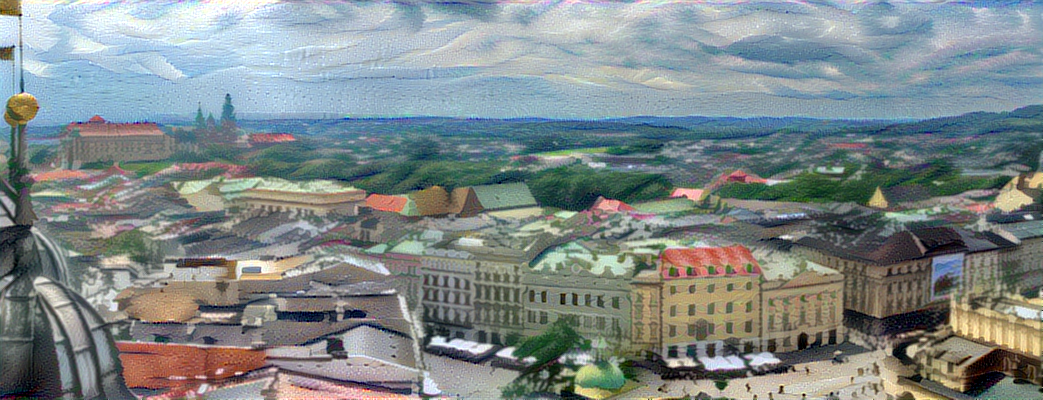

In [39]:
Image(filename=transfered_images[1], width=1000)

<HR>

<a id="clean"></a>
# 6. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
# 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `ibm-watson-machine-learning-client` to run experiments.

### Citations

- <a href="https://commons.wikimedia.org/wiki/User:Rj1979">Rj1979</a>, <a href="https://commons.wikimedia.org/wiki/File:Kraków_239a.jpg">Kraków 239a</a>, marked as public domain, more details on <a href="https://commons.wikimedia.org/wiki/Template:PD-self">Wikimedia Commons</a>
- <a href="https://en.wikipedia.org/wiki/en:Vincent_van_Gogh">Vincent van Gogh</a>, <a href="https://commons.wikimedia.org/wiki/File:Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg">Van Gogh - Starry Night - Google Art Project</a>, marked as public domain, more details on <a href="https://commons.wikimedia.org/wiki/Template:PD-1923">Wikimedia Commons</a>
- <a href="https://en.wikipedia.org/wiki/en:Wassily_Kandinsky">Wassily Kandinski</a>, <a href="https://commons.wikimedia.org/wiki/File:Kandinsky,_Lyrisches.jpg">Kandinsky, Lyrisches</a>, marked as public domain, more details on <a href="https://commons.wikimedia.org/wiki/Template:PD-1923">Wikimedia Commons</a>


### Author

**Jan Sołtysik**, Intern in Watson Machine Learning.

Copyright © 2020, 2021 IBM. This notebook and its source code are released under the terms of the MIT License.